# PUC Minas
## Pós Graduação em Ciência de Dados e Big Data (2022-2023)
## Trabalho de Conclusão de Curso
## Aluno: Frank Tetsuya Komati
### Este notebook é relativo ao meu Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. O título é ANÁLISE E PREVISÃO DE SÉRIES TEMPORAIS DE DADOS DE EXPORTAÇÃO DE MINÉRIO DE FERRO PELO ESPÍRITO SANTO, neste trabalho o dataset foi baixado no site dados.gov.br.

In [1]:
# Carregamento das bibliotecas para tratamento das informações

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import statsmodels.api as sm
import pmdarima as pmd
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import csv
import datetime


In [2]:
# Carregamento das bases de dados

exportacao22 = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\EXP_2022.csv')
exportacao21 = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\EXP_2021.csv', delimiter=';')
exportacao20 = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\EXP_2020.csv', delimiter=';')
exportacao19 = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\EXP_2019.csv', delimiter=';')
exportacao18 = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\EXP_2018.csv', delimiter=';')



In [3]:
# Exibindo os cabeçalhos

print(exportacao22.dtypes)

CO_ANO         int64
CO_MES         int64
CO_NCM         int64
CO_UNID        int64
CO_PAIS        int64
SG_UF_NCM     object
CO_VIA         int64
CO_URF         int64
QT_ESTAT       int64
KG_LIQUIDO     int64
VL_FOB         int64
dtype: object


In [4]:
exportacao22.describe()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
count,1246126.0,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06,1.246126e+06
mean,2022.0,5.603824e+00,5.205261e+07,1.068043e+01,3.818627e+02,3.122577e+00,7.979867e+05,3.536106e+05,4.950924e+05,2.252222e+05
std,0.0,2.834478e+00,3.113172e+07,1.697152e+00,2.402686e+02,2.654398e+00,3.211893e+05,3.455706e+07,4.102165e+07,5.095228e+06
min,2022.0,1.000000e+00,1.012100e+06,1.000000e+01,1.300000e+01,0.000000e+00,1.176000e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.0,3.000000e+00,2.106100e+07,1.000000e+01,1.630000e+02,1.000000e+00,8.176000e+05,5.000000e+00,5.000000e+00,9.200000e+01
50%,2022.0,6.000000e+00,5.806310e+07,1.000000e+01,3.510000e+02,1.000000e+00,8.178000e+05,3.600000e+01,4.200000e+01,8.670000e+02
75%,2022.0,8.000000e+00,8.432900e+07,1.100000e+01,5.860000e+02,4.000000e+00,9.178000e+05,6.580000e+02,1.090000e+03,1.334100e+04
max,2022.0,1.000000e+01,9.706900e+07,2.200000e+01,8.900000e+02,1.500000e+01,9.999999e+06,1.391698e+10,2.403087e+10,1.100695e+09


In [5]:
exportacao18.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,2018,1,39162000,10,756,RS,1,1017700,61,61,803
1,2018,1,84835090,11,399,SP,4,817600,16,2,138
2,2018,1,87019490,11,158,PR,7,1017500,3,16410,98940
3,2018,1,73209000,10,589,SP,4,817600,10003,6,916
4,2018,1,25070010,10,386,CE,4,317901,10,10,10


In [6]:
# Criando uma lista com as informações importadas

lista_exportacao = [exportacao22, exportacao21, exportacao20, exportacao19, exportacao18]

In [7]:
# Concatenando as informações em um dataframe

exportacao = pd.concat(lista_exportacao)


In [8]:
print(exportacao)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  \
0          2022      10  30049069       10      493        SP       1   
1          2022       5  11029000       10       77        SC       1   
2          2022       9  87085099       10       63        RS       7   
3          2022       1  84141000       11      158        RS       7   
4          2022       5  33061000       10      607        ES       1   
...         ...     ...       ...      ...      ...       ...     ...   
1128976    2018      12  90318030       11      249        SP       4   
1128977    2018      12  38099190       10      573        SP       1   
1128978    2018      12  84819090       10      158        RJ       7   
1128979    2018      12  84329000       10      386        SP       1   
1128980    2018      12  33042090       10      351        PR       4   

          CO_URF  QT_ESTAT  KG_LIQUIDO  VL_FOB  
0         817800     18768       18768  140235  
1         927700         

In [9]:
# Carregamento das tabelas auxiliares - Paises

paises = pd.read_csv('D:\OneDrive\Desktop\Python\TCC\Paises.csv', sep=";", encoding = 'utf-8')

In [10]:
# Carregamento das tabelas auxiliares - NCM

NCM = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\NCM.csv', sep=";", encoding = 'utf-8')

In [11]:
# Carregamento das tabelas auxiliares - Via

via = pd.read_csv(r'D:\OneDrive\Desktop\Python\TCC\via.csv', sep=";", encoding = 'utf-8')

In [12]:
print(paises)

     CO_PAIS  CO_PAIS_ISON3 CO_PAIS_ISOA3                      NO_PAIS  \
0          0            898           ZZZ                 Não Definido   
1         13              4           AFG                  Afeganistão   
2         15            248           ALA                 Aland, Ilhas   
3         17              8           ALB                      Albânia   
4         20            724           ESP       Alboran-Perejil, Ilhas   
..       ...            ...           ...                          ...   
276      994            898           ZZZ                   A Designar   
277      995            898           ZZZ              Bancos Centrais   
278      997            898           ZZZ  Organizações Internacionais   
279      998            898           ZZZ               Sem informação   
280      999            898           ZZZ               Não Declarados   

                     NO_PAIS_ING                     NO_PAIS_ESP  
0                    Not defined            

In [13]:
print(NCM)

         CO_NCM                                         NO_NCM_POR  CO_PPE  \
0       1011010                  Cavalos reprodutores de raça pura    1990   
1       1011090  Animais da espécie asinina/muar, reprodutores,...    1990   
2       1011100                 Cavalos reprodutores, de raça pura    1990   
3       1011900                              Outros cavalos, vivos    1990   
4       1012000                            Asininos e muares vivos    1990   
...         ...                                                ...     ...   
13315  99997103            Joalheria de ouro do capitulo 71 da NCM    4020   
13316  99997104               Outros artigos do capitulo 71 da NCM    4020   
13317  99999900    Qualquer outra mercadoria sem cobertura cambial    4010   
13318  99999951      Devolução antes da DI (exportação definitiva)    6010   
13319  99999960                                       Reexportação    6010   

                                                  NO_PPE  \
0  

In [14]:
print(via)

    CO_VIA                       NO_VIA
0       99             VIA DESCONHECIDA
1       13                  POR REBOQUE
2       11                      COURIER
3       15          VICINAL FRONTEIRICO
4       14                        DUTOS
5       12                      EM MAOS
6        0            VIA NAO DECLARADA
7        1                     MARITIMA
8        2                      FLUVIAL
9        3                     LACUSTRE
10       4                        AEREA
11       5                       POSTAL
12       6                  FERROVIARIA
13       7                   RODOVIARIA
14       8  CONDUTO/REDE DE TRANSMISSAO
15       9               MEIOS PROPRIOS
16      10          ENTRADA/SAIDA FICTA


In [15]:
# Criando um merge da tabela principal com a tabela auxiliar - NCM

exportacao = pd.merge(exportacao, NCM, how='left', on='CO_NCM')

In [16]:
print(exportacao)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  \
0          2022      10  30049069       10      493        SP       1   
1          2022       5  11029000       10       77        SC       1   
2          2022       9  87085099       10       63        RS       7   
3          2022       1  84141000       11      158        RS       7   
4          2022       5  33061000       10      607        ES       1   
...         ...     ...       ...      ...      ...       ...     ...   
6593127    2018      12  90318030       11      249        SP       4   
6593128    2018      12  38099190       10      573        SP       1   
6593129    2018      12  84819090       10      158        RJ       7   
6593130    2018      12  84329000       10      386        SP       1   
6593131    2018      12  33042090       10      351        PR       4   

          CO_URF  QT_ESTAT  KG_LIQUIDO  VL_FOB  \
0         817800     18768       18768  140235   
1         927700       

In [17]:
# Criando um merge da tabela principal com a tabela auxiliar - Pais

exportacao = pd.merge(exportacao, paises, how='left', on='CO_PAIS')

In [18]:
print(exportacao)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  \
0          2022      10  30049069       10      493        SP       1   
1          2022       5  11029000       10       77        SC       1   
2          2022       9  87085099       10       63        RS       7   
3          2022       1  84141000       11      158        RS       7   
4          2022       5  33061000       10      607        ES       1   
...         ...     ...       ...      ...      ...       ...     ...   
6593127    2018      12  90318030       11      249        SP       4   
6593128    2018      12  38099190       10      573        SP       1   
6593129    2018      12  84819090       10      158        RJ       7   
6593130    2018      12  84329000       10      386        SP       1   
6593131    2018      12  33042090       10      351        PR       4   

          CO_URF  QT_ESTAT  KG_LIQUIDO  ...  \
0         817800     18768       18768  ...   
1         927700         6   

In [19]:
# Criando um merge da tabela principal com a tabela auxiliar - Via

exportacao = pd.merge(exportacao, via, how='left', on='CO_VIA')

In [20]:
print(exportacao)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  \
0          2022      10  30049069       10      493        SP       1   
1          2022       5  11029000       10       77        SC       1   
2          2022       9  87085099       10       63        RS       7   
3          2022       1  84141000       11      158        RS       7   
4          2022       5  33061000       10      607        ES       1   
...         ...     ...       ...      ...      ...       ...     ...   
6593127    2018      12  90318030       11      249        SP       4   
6593128    2018      12  38099190       10      573        SP       1   
6593129    2018      12  84819090       10      158        RJ       7   
6593130    2018      12  84329000       10      386        SP       1   
6593131    2018      12  33042090       10      351        PR       4   

          CO_URF  QT_ESTAT  KG_LIQUIDO  ...  CO_PPE  \
0         817800     18768       18768  ...  3338.0   
1         927

In [21]:
#Principais estados exportadores 

exportacao['date_exportacao'] = pd.to_datetime(exportacao['CO_ANO'].astype(str) + 
                                                    '-' + exportacao['CO_MES'].astype(str).str.zfill(2) + '-01')



In [22]:
print(exportacao)


         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  \
0          2022      10  30049069       10      493        SP       1   
1          2022       5  11029000       10       77        SC       1   
2          2022       9  87085099       10       63        RS       7   
3          2022       1  84141000       11      158        RS       7   
4          2022       5  33061000       10      607        ES       1   
...         ...     ...       ...      ...      ...       ...     ...   
6593127    2018      12  90318030       11      249        SP       4   
6593128    2018      12  38099190       10      573        SP       1   
6593129    2018      12  84819090       10      158        RJ       7   
6593130    2018      12  84329000       10      386        SP       1   
6593131    2018      12  33042090       10      351        PR       4   

          CO_URF  QT_ESTAT  KG_LIQUIDO  ...  \
0         817800     18768       18768  ...   
1         927700         6   

In [23]:
exportacao_prod = exportacao[(exportacao["SG_UF_NCM"] == "ES") & 
                             (exportacao["CO_VIA"] == 1) & 
                             (exportacao["KG_LIQUIDO"] > 0)]

In [24]:
print(exportacao_prod)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  CO_URF  \
4          2022       5  33061000       10      607        ES       1  727600   
64         2022       7   7061000       10      160        ES       1  727600   
71         2022       9  16041310       10      580        ES       1  727600   
118        2022       8   7049000       10      434        ES       1  717800   
119        2022       5  16025000       10      434        ES       1  727600   
...         ...     ...       ...      ...      ...       ...     ...     ...   
6592889    2018      10  34029090       10      301        ES       1  727600   
6592995    2018      10   4039000       10      386        ES       1  727600   
6593026    2018      12   2091011       10      476        ES       1  727600   
6593061    2018      12   7069000       10      628        ES       1  727600   
6593083    2018      12   3061710       10      741        ES       1  727600   

         QT_ESTAT  KG_LIQUI

In [25]:
exportacao_prod = exportacao_prod.groupby(['CO_ANO', 'NO_PPE', 'SG_UF_NCM'])['VL_FOB'].sum().sort_values(ascending=False).to_frame()

In [26]:
print(exportacao_prod)

                                                                         VL_FOB
CO_ANO NO_PPE                                             SG_UF_NCM            
2021   MINERIOS DE FERRO E SEUS CONCENTRADOS              ES         3326195391
2018   MINERIOS DE FERRO E SEUS CONCENTRADOS              ES         2906063651
2022   MINERIOS DE FERRO E SEUS CONCENTRADOS              ES         2289053209
2019   MINERIOS DE FERRO E SEUS CONCENTRADOS              ES         2048489151
2021   PRODUTOS SEMIMANUFATURADOS DE FERRO OU ACOS        ES         1887422668
...                                                                         ...
2018   ARDOSIA NATURAL E OBRAS DE ARDOSIA                 ES                  4
       INSTRUMENTOS E APARELHOS MEDICOS                   ES                  4
2020   ETERES ALCOOLICOS E SEUS DERIVADOS                 ES                  3
2019   MOLDES PARA METAIS,VIDRO,MINERAIS, BORRACHA OU ... ES                  2
2022   ETERES ALCOOLICOS E SEUS DERIVADO

In [27]:
lista_exportacao_es = [exportacao_prod.query('SG_UF_NCM == "ES" & CO_ANO == 2018').head(5), 
                    exportacao_prod.query('SG_UF_NCM == "ES" & CO_ANO == 2019').head(5), 
                    exportacao_prod.query('SG_UF_NCM == "ES" & CO_ANO == 2020').head(5), 
                    exportacao_prod.query('SG_UF_NCM == "ES" & CO_ANO == 2021').head(5), 
                    exportacao_prod.query('SG_UF_NCM == "ES" & CO_ANO == 2022').head(5)]

In [28]:
print(lista_exportacao_es)

[                                                                  VL_FOB
CO_ANO NO_PPE                                      SG_UF_NCM            
2018   MINERIOS DE FERRO E SEUS CONCENTRADOS       ES         2906063651
       PRODUTOS SEMIMANUFATURADOS DE FERRO OU ACOS ES         1332719124
       OLEOS BRUTOS DE PETROLEO                    ES          959972646
       CELULOSE                                    ES          920246216
       PRODUTOS LAMINADOS PLANOS DE FERRO OU ACOS  ES          660118689,                                                                   VL_FOB
CO_ANO NO_PPE                                      SG_UF_NCM            
2019   MINERIOS DE FERRO E SEUS CONCENTRADOS       ES         2048489151
       PRODUTOS SEMIMANUFATURADOS DE FERRO OU ACOS ES         1034147044
       OLEOS BRUTOS DE PETROLEO                    ES         1014453632
       CELULOSE                                    ES          604862304
       PRODUTOS LAMINADOS PLANOS DE FERRO OU ACOS

                                                                  VL_FOB
CO_ANO NO_PPE                                      SG_UF_NCM            
2018   MINERIOS DE FERRO E SEUS CONCENTRADOS       ES         2906063651
       PRODUTOS SEMIMANUFATURADOS DE FERRO OU ACOS ES         1332719124
       OLEOS BRUTOS DE PETROLEO                    ES          959972646
       CELULOSE                                    ES          920246216
       PRODUTOS LAMINADOS PLANOS DE FERRO OU ACOS  ES          660118689
2019   MINERIOS DE FERRO E SEUS CONCENTRADOS       ES         2048489151
       PRODUTOS SEMIMANUFATURADOS DE FERRO OU ACOS ES         1034147044
       OLEOS BRUTOS DE PETROLEO                    ES         1014453632
       CELULOSE                                    ES          604862304
       PRODUTOS LAMINADOS PLANOS DE FERRO OU ACOS  ES          530567515
2020   MINERIOS DE FERRO E SEUS CONCENTRADOS       ES         1158714902
       CELULOSE                                    

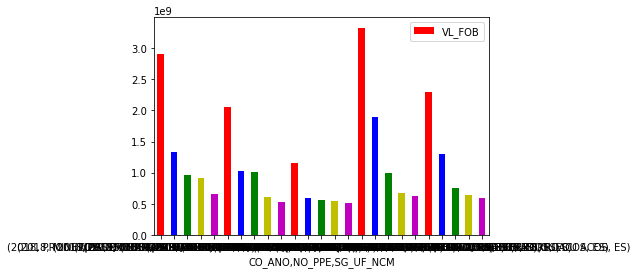

In [29]:
exportacao_grafico = pd.concat(lista_exportacao_es)
print(exportacao_grafico)
axis = exportacao_grafico.plot.bar(y='VL_FOB', rot=0, color=['r', 'b', 'g', 'y', 'm'])
print(axis)
plt.show()

In [30]:
# Filtrando dados - Selecionando apenas as informações de exportação de minério de ferro e seus 
# concentrados pelos ES via Marítima 

exportacao_es_t = exportacao[(exportacao["NO_PPE"] == "MINERIOS DE FERRO E SEUS CONCENTRADOS") & 
                             (exportacao["SG_UF_NCM"] == "ES") & 
                             (exportacao["CO_VIA"] == 1) & 
                             (exportacao["KG_LIQUIDO"] > 0)]

In [31]:
print(exportacao_es_t)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  CO_URF  \
16297      2022       2  26011210       10      399        ES       1  727600   
27152      2022       2  26011210       10      246        ES       1  727600   
29898      2022       9  26011210       10      160        ES       1  727600   
73951      2022       7  26011210       10       63        ES       1  727600   
75233      2022       9  26011210       10      815        ES       1  727600   
...         ...     ...       ...      ...      ...       ...     ...     ...   
6524046    2018       4  26011210       10      249        ES       1  727600   
6527780    2018       3  26011210       10      756        ES       1  727600   
6529686    2018       6  26011210       10      386        ES       1  727600   
6577414    2018       1  26011210       10      275        ES       1  727600   
6578645    2018       6  26011210       10      756        ES       1  727600   

          QT_ESTAT  KG_LIQU

In [32]:
exportacao_es_dest = exportacao_es_t.groupby(['NO_PAIS'])['KG_LIQUIDO'].sum().sort_values(ascending=False).to_frame()

In [33]:
exportacao_es_dest.head(10)

,KG_LIQUIDO
NO_PAIS,
Estados Unidos,12176678190
Egito,11823316333
Argentina,10629558392
Japão,9937475100
China,9529123629
Trinidad e Tobago,5359113000
Líbia,4039822000
Coreia do Sul,3894104388
Itália,2885850000


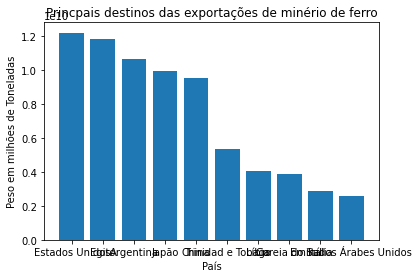

In [34]:
df_10 = exportacao_es_dest.reset_index().head(10)

fig, ax = plt.subplots()
ax.bar(df_10["NO_PAIS"], df_10["KG_LIQUIDO"])
ax.set_xlabel("País")
ax.set_ylabel("Peso em milhões de Toneladas")
ax.set_title("Princpais destinos das exportações de minério de ferro")

plt.show()

<AxesSubplot:>

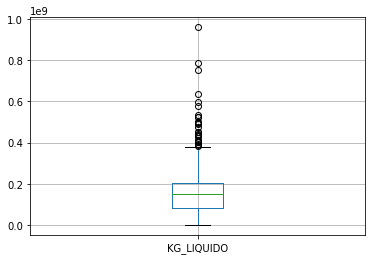

In [35]:
# Verificando os outliers

exportacao_es_t.boxplot('KG_LIQUIDO')

In [36]:
print(exportacao_es_t)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  CO_URF  \
16297      2022       2  26011210       10      399        ES       1  727600   
27152      2022       2  26011210       10      246        ES       1  727600   
29898      2022       9  26011210       10      160        ES       1  727600   
73951      2022       7  26011210       10       63        ES       1  727600   
75233      2022       9  26011210       10      815        ES       1  727600   
...         ...     ...       ...      ...      ...       ...     ...     ...   
6524046    2018       4  26011210       10      249        ES       1  727600   
6527780    2018       3  26011210       10      756        ES       1  727600   
6529686    2018       6  26011210       10      386        ES       1  727600   
6577414    2018       1  26011210       10      275        ES       1  727600   
6578645    2018       6  26011210       10      756        ES       1  727600   

          QT_ESTAT  KG_LIQU

In [37]:
# Removendo os outliers calculando o intervalo interquartil (IIQ) e os limites inferior e superior, utilizando uma constante 
# que geralmente recebe o valor 1,5.

def drop_outliers(df, field_name):
    distance = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)
    
drop_outliers(exportacao_es_t, "KG_LIQUIDO")    

<ipython-input-37-a5c4a0b67991>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
<ipython-input-37-a5c4a0b67991>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)


<AxesSubplot:>

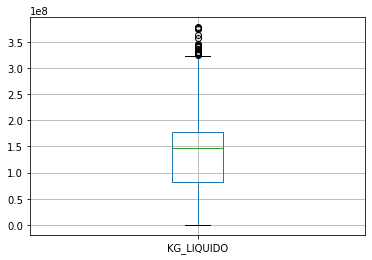

In [38]:
exportacao_es_t.boxplot('KG_LIQUIDO')

In [39]:
print(exportacao_es_t)

         CO_ANO  CO_MES    CO_NCM  CO_UNID  CO_PAIS SG_UF_NCM  CO_VIA  CO_URF  \
16297      2022       2  26011210       10      399        ES       1  727600   
27152      2022       2  26011210       10      246        ES       1  727600   
29898      2022       9  26011210       10      160        ES       1  727600   
73951      2022       7  26011210       10       63        ES       1  727600   
75233      2022       9  26011210       10      815        ES       1  727600   
...         ...     ...       ...      ...      ...       ...     ...     ...   
6524046    2018       4  26011210       10      249        ES       1  727600   
6527780    2018       3  26011210       10      756        ES       1  727600   
6529686    2018       6  26011210       10      386        ES       1  727600   
6577414    2018       1  26011210       10      275        ES       1  727600   
6578645    2018       6  26011210       10      756        ES       1  727600   

          QT_ESTAT  KG_LIQU

In [40]:
print(exportacao_es_t.dtypes)

CO_ANO                      int64
CO_MES                      int64
CO_NCM                      int64
CO_UNID                     int64
CO_PAIS                     int64
SG_UF_NCM                  object
CO_VIA                      int64
CO_URF                      int64
QT_ESTAT                    int64
KG_LIQUIDO                  int64
VL_FOB                      int64
NO_NCM_POR                 object
CO_PPE                    float64
NO_PPE                     object
NO_PPE_MIN                 object
NO_PPE_ING                 object
CO_PAIS_ISON3               int64
CO_PAIS_ISOA3              object
NO_PAIS                    object
NO_PAIS_ING                object
NO_PAIS_ESP                object
NO_VIA                     object
date_exportacao    datetime64[ns]
dtype: object


In [41]:
#Criando um campo data que será o indíce a ser utilizado no dataframe

exportacao_es_t['date_exportacao'] = pd.to_datetime(exportacao_es_t['CO_ANO'].astype(str) + 
                                                    '-' + exportacao_es_t['CO_MES'].astype(str).str.zfill(2) + '-01')

<ipython-input-41-5853c0b628fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exportacao_es_t['date_exportacao'] = pd.to_datetime(exportacao_es_t['CO_ANO'].astype(str) +


In [42]:
#Agrupando pela quantidade

exportacao_es = exportacao_es_t.groupby(['date_exportacao', 'CO_ANO', 'CO_MES', 'NO_PPE', 
                                         'SG_UF_NCM', 'NO_VIA'])['KG_LIQUIDO'].sum().sort_values(ascending=False).to_frame()


In [43]:
exportacao_es.describe()

,KG_LIQUIDO
count,5.800000e+01
mean,1.300023e+09
std,5.258341e+08
min,3.079820e+08
25%,8.851119e+08
50%,1.307044e+09
75%,1.616081e+09
max,2.428653e+09


In [44]:
print(exportacao_es)

                                                                                        KG_LIQUIDO
date_exportacao CO_ANO CO_MES NO_PPE                                SG_UF_NCM NO_VIA              
2018-11-01      2018   11     MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2428653000
2018-09-01      2018   9      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2414618000
2019-01-01      2019   1      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2260096000
2018-07-01      2018   7      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2196843000
2018-05-01      2018   5      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2153619388
2018-10-01      2018   10     MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  2119145000
2022-09-01      2022   9      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  1993066000
2019-03-01      2019   3      MINERIOS DE FERRO E SEUS CONCENTRADOS ES        MARITIMA  1912878000
2018-08-01

In [45]:
print(exportacao_es.dtypes)

KG_LIQUIDO    int64
dtype: object


In [46]:
exportacao_es = exportacao_es.sort_values(by="date_exportacao")

In [47]:
exportacao_es = exportacao_es.groupby(['date_exportacao']).KG_LIQUIDO.sum()

In [48]:
exportacao_es.describe()

count    5.800000e+01
mean     1.300023e+09
std      5.258341e+08
min      3.079820e+08
25%      8.851119e+08
50%      1.307044e+09
75%      1.616081e+09
max      2.428653e+09
Name: KG_LIQUIDO, dtype: float64

In [49]:
exportacao_es

date_exportacao
2018-01-01    1801556000
2018-02-01    1726320000
2018-03-01    1479653186
2018-04-01    1417832000
2018-05-01    2153619388
2018-06-01    1525517000
2018-07-01    2196843000
2018-08-01    1902545000
2018-09-01    2414618000
2018-10-01    2119145000
2018-11-01    2428653000
2018-12-01    1857282000
2019-01-01    2260096000
2019-02-01    1396821000
2019-03-01    1912878000
2019-04-01    1446903000
2019-05-01    1029873000
2019-06-01    1083061000
2019-07-01    1573949000
2019-08-01    1359944000
2019-09-01    1224776000
2019-10-01    1431877000
2019-11-01     996533000
2019-12-01    1619877000
2020-01-01    1183702440
2020-02-01     708822000
2020-03-01     698259000
2020-04-01     748564000
2020-05-01     307982000
2020-06-01     446607000
2020-07-01     848201000
2020-08-01     808019000
2020-09-01     926763000
2020-10-01    1210852000
2020-11-01     401619000
2020-12-01     799482001
2021-01-01     676064000
2021-02-01     568522000
2021-03-01    1439993000
2021-04-0

In [50]:
exportacao_es_prophet = exportacao_es.reset_index(name='y')
exportacao_es_prophet.rename(columns={'date_exportacao': 'ds'}, inplace=True)

In [51]:
print(exportacao_es_prophet)

           ds           y
0  2018-01-01  1801556000
1  2018-02-01  1726320000
2  2018-03-01  1479653186
3  2018-04-01  1417832000
4  2018-05-01  2153619388
5  2018-06-01  1525517000
6  2018-07-01  2196843000
7  2018-08-01  1902545000
8  2018-09-01  2414618000
9  2018-10-01  2119145000
10 2018-11-01  2428653000
11 2018-12-01  1857282000
12 2019-01-01  2260096000
13 2019-02-01  1396821000
14 2019-03-01  1912878000
15 2019-04-01  1446903000
16 2019-05-01  1029873000
17 2019-06-01  1083061000
18 2019-07-01  1573949000
19 2019-08-01  1359944000
20 2019-09-01  1224776000
21 2019-10-01  1431877000
22 2019-11-01   996533000
23 2019-12-01  1619877000
24 2020-01-01  1183702440
25 2020-02-01   708822000
26 2020-03-01   698259000
27 2020-04-01   748564000
28 2020-05-01   307982000
29 2020-06-01   446607000
30 2020-07-01   848201000
31 2020-08-01   808019000
32 2020-09-01   926763000
33 2020-10-01  1210852000
34 2020-11-01   401619000
35 2020-12-01   799482001
36 2021-01-01   676064000
37 2021-02-0

Text(0, 0.5, 'KG_LIQUIDO')

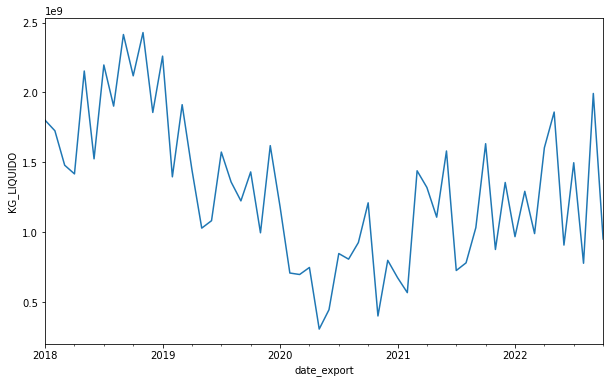

In [52]:
exportacao_es.plot(figsize=(10,6))
plt.xlabel('date_export')
plt.ylabel('KG_LIQUIDO')

<Figure size 7200x1440 with 0 Axes>

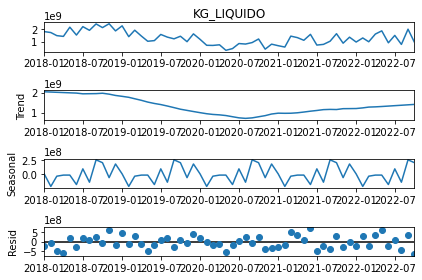

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado_decom = seasonal_decompose(exportacao_es, period=12, extrapolate_trend=5)

fig = plt.figure(figsize=(100,20))
fig = resultado_decom.plot()

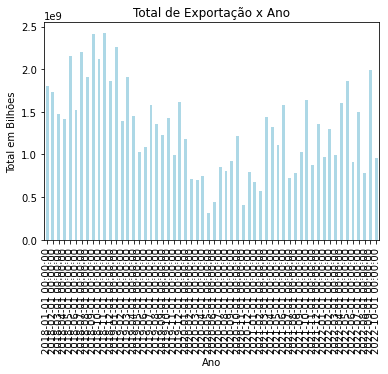

In [54]:
# Plotando gráfico: Total de recebimentos x Ano
ax = exportacao_es.plot(kind='bar',color='lightblue',title='Total de Exportação x Ano')

ax.set_ylabel('Total em Bilhões')
ax.set_xlabel('Ano')

plt.show()

In [55]:
# 

from pmdarima import auto_arima

fit_arima = auto_arima(exportacao_es, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                      seasonal=True,
                      m=6,
                      D=1,
                      start_P=1,
                      start_Q=1,
                      max_P=2,
                      max_Q=2,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      stewise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=2187.087, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2213.424, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2190.490, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2192.413, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2185.634, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=2195.868, Time=0.05 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2186.518, Time=0.26 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=2192.107, Time=0.06 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=2184.888, Time=0.21 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=2186.398, Time=0.19 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=2185.460, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=2193.362, Time=0.17 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=2183.359, Time=0.19 sec
 ARIMA(1,1,0)(0,1,2)[6]             : AIC=2184.980, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[6]          

In [56]:
modelo = SARIMAX(exportacao_es, 
                 order=(1,1,0),
                 enforce_invertibility=False, 
                 enforce_stationarity=True, 
                 seasonal_order=(1,1,2,6))

resultado = modelo.fit()

resultado.summary()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             KG_LIQUIDO   No. Observations:                   58
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 6)   Log Likelihood               -1086.679
Date:                                Fri, 07 Apr 2023   AIC                           2183.359
Time:                                        21:54:58   BIC                           2193.018
Sample:                                    01-01-2018   HQIC                          2187.050
                                         - 10-01-2022                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6480      0.186     -3.475      0.001      -1.014      -0.283
ar.S.L6       -0.5802      0.458     -1.268      0.205      -1.477       0.317
ma.S.L6        0.1785      0.654      0.273      0.785      -1.103       1.460
ma.S.L12      -0.6038      0.341     -1.771      0.077      -1.272       0.065
sigma2      2.498e+17   2.53e-18   9.86e+34      0.000     2.5e+17     2.5e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.71   Prob(JB):                         0.56
Heteroskedasticity (H):               1.50   Skew:                             0.37
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.97e+50. Standard errors may be unstable.
"""

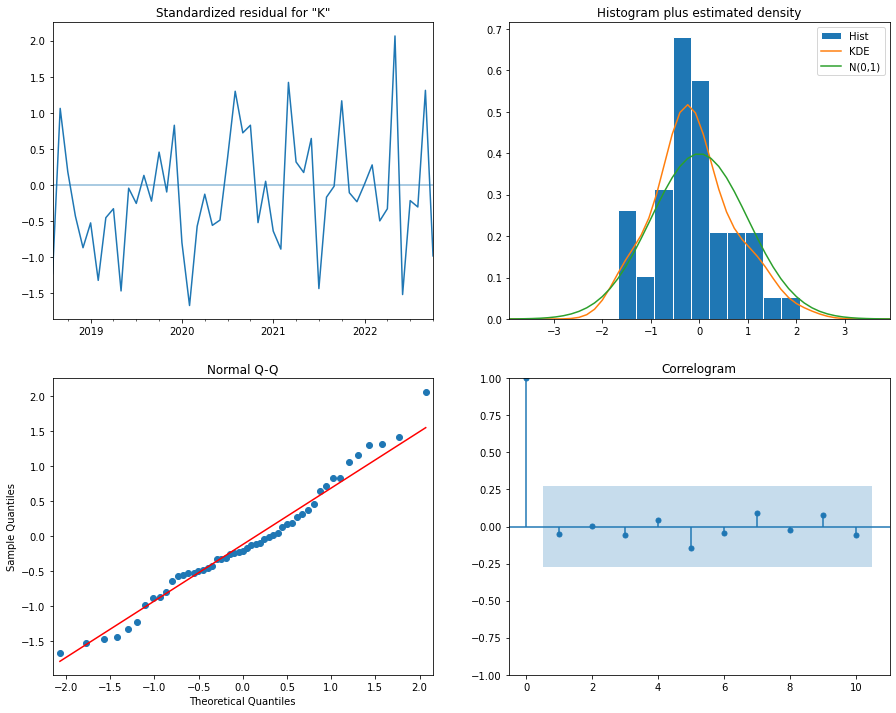

In [57]:
resultado.plot_diagnostics(figsize=(15, 12))
plt.show()

In [58]:
predicoes = resultado.get_prediction(start=12)

predicao_media = predicoes.predicted_mean

print(predicao_media)

2019-01-01    2.541935e+09
2019-02-01    2.083937e+09
2019-03-01    2.148766e+09
2019-04-01    1.618223e+09
2019-05-01    1.792862e+09
2019-06-01    1.106442e+09
2019-07-01    1.706824e+09
2019-08-01    1.291404e+09
2019-09-01    1.341112e+09
2019-10-01    1.196331e+09
2019-11-01    1.047065e+09
2019-12-01    1.193276e+09
2020-01-01    1.593136e+09
2020-02-01    1.556751e+09
2020-03-01    9.894662e+08
2020-04-01    8.136624e+08
2020-05-01    5.921782e+08
2020-06-01    6.939485e+08
2020-07-01    6.570005e+08
2020-08-01    1.493127e+08
2020-09-01    5.605438e+08
2020-10-01    7.911513e+08
2020-11-01    6.664868e+08
2020-12-01    7.737616e+08
2021-01-01    9.991704e+08
2021-02-01    1.016508e+09
2021-03-01    7.243244e+08
2021-04-01    1.160314e+09
2021-05-01    1.021444e+09
2021-06-01    1.257340e+09
2021-07-01    1.450126e+09
2021-08-01    8.669993e+08
2021-09-01    1.042723e+09
2021-10-01    1.046854e+09
2021-11-01    9.316026e+08
2021-12-01    1.473573e+09
2022-01-01    9.625944e+08
2

In [59]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(exportacao_es.index)

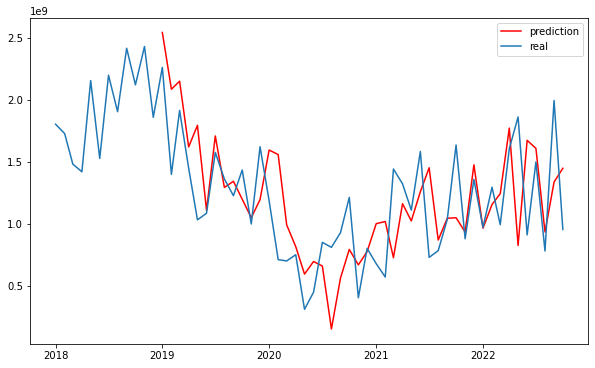

In [60]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao, predicao_media.values, color='red', label='prediction')
plt.plot(datas, exportacao_es.values, label='real')
plt.legend()
plt.show()

In [61]:
#Calculo RMSE SARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(exportacao_es[-46:].values, predicao_media.values))

print(rmse_sarima)

411521808.5399549


In [62]:
forecast = resultado.get_forecast(steps=12)

forecast_medio = forecast.predicted_mean

forecast_medio.size

12

In [63]:
forecast_medio[0]

1898869710.8233848

In [64]:
datas_forecast = np.asarray(forecast_medio.index)
datas = np.asarray(exportacao_es.index)

datas_previsao = np.asarray(predicao_media.index)

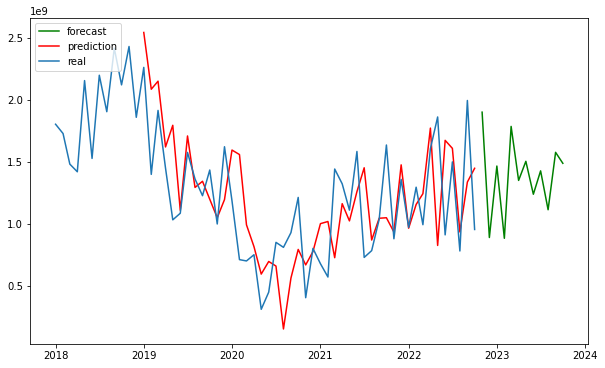

In [65]:
plt.figure(figsize=(10,6))
plt.plot(datas_forecast, forecast_medio.values, color='green', label='forecast')
plt.plot(datas_previsao, predicao_media.values, color='red', label='prediction')
plt.plot(datas, exportacao_es.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [66]:
# Utilizando o Prophet
from sklearn.model_selection import train_test_split

exportacao_es_prophet = exportacao_es.reset_index(name='y')
exportacao_es_prophet.rename(columns={'date_exportacao': 'ds'}, inplace=True)

train_data_prophet, test_data_prophet = train_test_split(exportacao_es_prophet, test_size=0.2, shuffle=False)

model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing


<ipython-input-67-9b44d2854f05>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


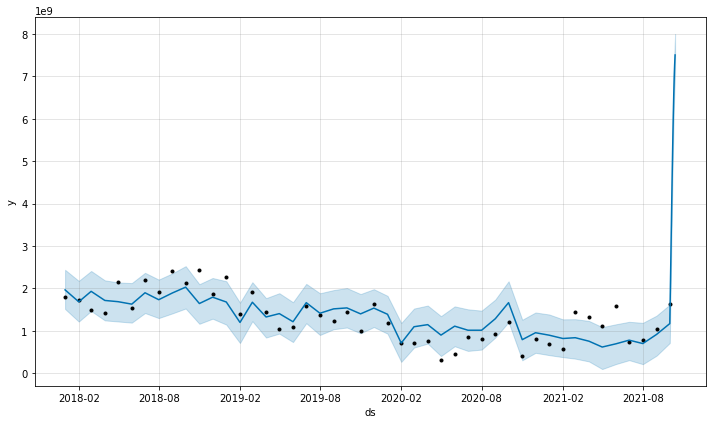

In [67]:
future_prophet = model_prophet.make_future_dataframe(periods=len(test_data_prophet))
forecast_prophet = model_prophet.predict(future_prophet)
fig = model_prophet.plot(forecast_prophet)
fig.show()



In [68]:
# Calculando o RMSE Prophet
rmse_prophet = mean_squared_error(exportacao_es_prophet['y'], forecast_prophet['yhat'], squared=False)

print("Prophet RMSE:", rmse_prophet)

Prophet RMSE: 1943965158.241321


In [69]:
# Encontre os melhores parâmetros para o modelo ARIMA
model_arima = auto_arima(exportacao_es, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True, 
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2432.304, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2450.748, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2431.230, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2431.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2448.806, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2429.360, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2431.166, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2433.135, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2429.884, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2429.387, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2429.902, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2431.397, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=2427.270, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=2429.139, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1

In [70]:
# Imprima os parâmetros do modelo ARIMA encontrado
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1211.635
Date:                Fri, 07 Apr 2023   AIC                           2427.270
Time:                        21:55:13   BIC                           2431.357
Sample:                    01-01-2018   HQIC                          2428.858
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5453      0.073     -7.419      0.000      -0.689      -0.401
sigma2      1.542e+17   4.46e-20   3.46e+36      0.000    1.54e+17    1.54e+17
Ljung-Box (L1) (Q):                   2.48   Jarque-

In [71]:
# Crie o modelo ARIMA com parâmetros p, d, e q
model_arima = sm.tsa.ARIMA(exportacao_es, order=(1, 1, 0))

# Ajuste o modelo aos dados
results_arima = model_arima.fit()

# Imprima um resumo dos resultados
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             KG_LIQUIDO   No. Observations:                   58
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1211.635
Date:                Fri, 07 Apr 2023   AIC                           2427.270
Time:                        21:55:13   BIC                           2431.357
Sample:                    01-01-2018   HQIC                          2428.858
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5453      0.073     -7.419      0.000      -0.689      -0.401
sigma2      1.542e+17   4.46e-20   3.46e+36      0.000    1.54e+17    1.54e+17
Ljung-Box (L1) (Q):                   2.48   Jarque-

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


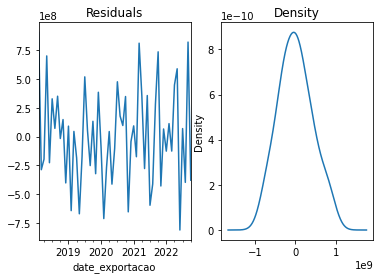

In [72]:
residuals_arima = results_arima.resid[1:]
fig, ax = plt.subplots(1,2)
residuals_arima.plot(title='Residuals', ax=ax[0])
residuals_arima.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


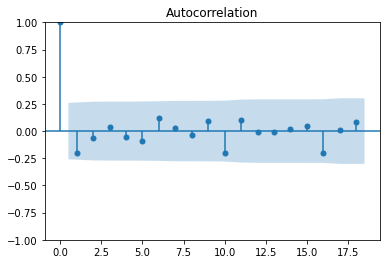

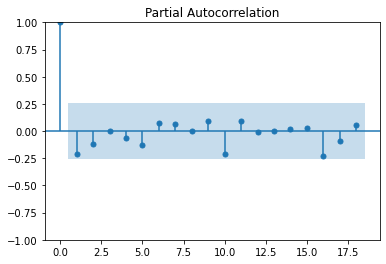

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_res = plot_acf(residuals_arima)

pacf_res = plot_pacf(residuals_arima)

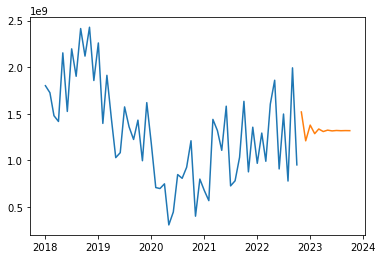

In [75]:
# Faça previsões para os próximos 12 períodos
forecast_arima = results_arima.predict(start=len(exportacao_es), end=len(exportacao_es)+11, dynamic=False)

# Visualize as previsões
plt.plot(exportacao_es)
plt.plot(forecast_arima)
plt.show()

In [76]:
# Calculando o RMSE para o ARIMA
rmse_arima = mean_squared_error(exportacao_es[-12:].values, forecast_arima, squared=False)


print(rmse_arima)

425523476.19877434
